In [50]:
# Yazılanlar ve reaksiyonlar için çok teşekkürler herkese.
# NLP kalan dersleri de atarım arkadaşlar bir aksilik olmazsa inşallah. Iyi çalışmalar...

# NLP Application with ML

## Classification of Tweets Data

Bu calismada ML modellerinin NLP ile nasil kullanildigina dair ornekler yaptik. (NLP' de DL modelleri ML modellerine gore daha cok tercih edilir)

### The Data

Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

Havayolu sirketlerine ait  atilan tweet' lerden olusan bir data. Datada yolcularin isimleri, yaptiklari yorumlar, havayolu sirketlerinin adi, tarih gibi bilgiler mevcut. Target label' da neutral, positive, negative olmak uzere 3 farkli class var. Butun NLP modellerinde sadece target ve text onemlidir, sadece bu ikisi ile islem yapacagiz.

__!!!__ NLP' de missing value' lar doldurulmaz, silinir. __!!!__

In [52]:
df = pd.read_csv("airline_tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [53]:
# !pip install matplotlib = 3.4 
# Matplotlib versiyonu 3.4 ten küçükse, 
# for p in ax.containers:
#     ax.bar_label(p)
# .. kodu çalışmayacaktır

Hangi havayoluna kac sikayet gelmis grafigini cizdirdik. Cok yogun sikayet alan havayolu sirketleri var :

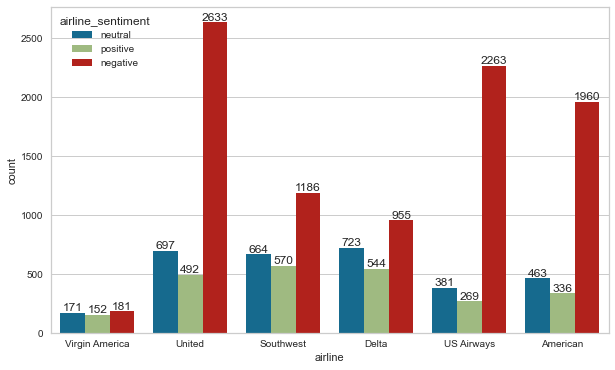

In [54]:
ax = sns.countplot(data = df, x ="airline", hue = "airline_sentiment")
for p in ax.containers:
    ax.bar_label(p)
# Her havayoluna yapılan ürünlerin kaçı positive-negative-neutral
# Her bar da birden fazla label varsa for döngüsünü kullanabiliriz(Kullanarak 3 bar-3 bar şeklinde gösterdi)
# united, Us Airways, American firmaları genelde(3 te 2 si) olumsuz yorum almışlar. Müşterilerin bizden kaçmaması için bir şeyler yapmamız gerekli

negativereason feature' ina gore bir grafik cizdirdik. Musterilerin cogu, musteri hizmetlerinden, gec ucuslardan vb. sikayetci diyebiliriz :

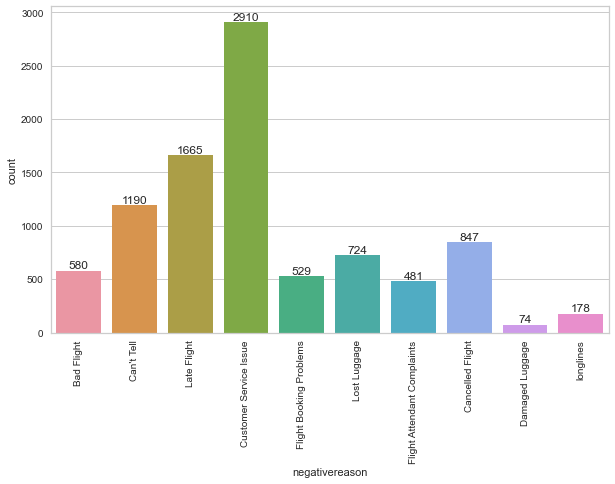

In [55]:
ax = sns.countplot(data =df, x ="negativereason")
ax.bar_label(ax.containers[0]) # tek label. for döngüsüne gerek yok
plt.xticks(rotation = 90);     # X eksenindeki isimleri 90 derece yazsın
# Negative yorum yapanlar neden negative yorum yaptılar

En fazla yorum negatif olarak yapilmis (Dengesiz bir dataseti) :

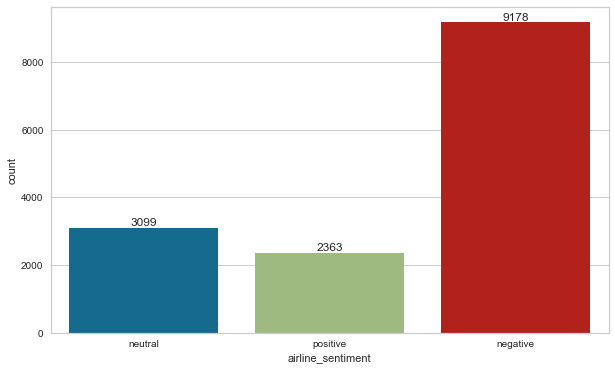

In [56]:
ax = sns.countplot(data =df, x = "airline_sentiment")
ax.bar_label(ax.containers[0]);
# Hedef label ım negative yorumlar. Benim için önemli bu. Müşterinin kaçmaması için bunlara yoğunlaşacağız

In [57]:
df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Cleaning Data

In [58]:
df2 = df.copy()

In [59]:
df2["text"].head() # Temizlenmemiş datamız

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

## Cleaning Data

Cleaning islemi icin regex kutuphanesini kullanacagiz. 

__re.sub -->__ Regexin bir fonksiyonudur. Asagida bu fonksiyon ile "http ile basla, bosluga kadar butun karakterleri temizle." demis olduk. com' dan sonra gelen bosluga kadar her seyi temizledi, sonraki kisimlar kaldi. Cumlenin basinda ve sonundaki bosluklari kaldirmak icin de __strip()__ kullandik :

__"http\S+", "" :__ http den sonra, boşluk "hariç" en az bir kere veya daha fazla karakter varsa hepsini al onların(http\\:www.mynet.com) yerine boşluk getir

In [60]:
# Önceki otomatik yaptığımız fonksiyona(cleaning) ilaveten bazı işlemler yapmalıyız
# tag ler, mention lar ve link lerin bize hiç bir katkısı yok. 
import re
s = "http\\:www.mynet.com #lateflight @airlines" # Text içerisinde link tag ve mention ımız var
s = re.sub("http\S+", "", s).strip()
s

'#lateflight @airlines'

__#__ ile baslayan tum ifadeleri boşluk hariç en az bir karakter varsa bosluga kadar temizle (strip yazmayinca basta bosluk kaldi) :

In [61]:
s = re.sub("#\S+", "", s)
s

' @airlines'

__@__ ile baslayan tum ifadeleri boşluk hariç en az bir karakter varsa bosluga kadar temizle :

In [62]:
s = re.sub("@\S+", "", s)
s.strip()

''

Yukarida temizledigimiz kelimeler her satirda oldugu icin modelde gürültüye sebep olur ve temizlenmeleri gerekir, egitime de bir katkilari yoktur.

In [63]:
#nltk.download('stopwords')

In [64]:
#nltk.download('wordnet')

In [65]:
"""negative_auxiliary_verbs = ["no", 'not', "n't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',
                            "doesn't", "don't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
                            'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',"needn't", 'shan', "shan't", 'shouldn',
                            "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', ,"won't", 'wouldn', "wouldn't"]"""

'negative_auxiliary_verbs = ["no", \'not\', "n\'t", \'ain\', \'aren\', "aren\'t", \'couldn\', "couldn\'t", \'didn\', "didn\'t", \'doesn\',\n                            "doesn\'t", "don\'t", \'hadn\', "hadn\'t", \'hasn\', "hasn\'t", \'haven\', "haven\'t", \'isn\', "isn\'t", \n                            \'ma\', \'mightn\', "mightn\'t", \'mustn\', "mustn\'t", \'needn\',"needn\'t", \'shan\', "shan\'t", \'shouldn\',\n                            "shouldn\'t", \'wasn\', "wasn\'t", \'weren\', "weren\'t", \'won\', ,"won\'t", \'wouldn\', "wouldn\'t"]'

Sentimental analiz yapacagimiz icin not ve no kelimeleri analiz icin gerekli. for dongusu ile bu kelimeleri stopwords' ler arasindan cikardik :

In [66]:
stop_words = stopwords.words('english')
for i in ["not", "no"]:
        stop_words.remove(i)

Tum cleaning islemlerini yapabilmek icin asagida cleaning isimli bir fonksiyon tanimladik.

Yukarida tek tek yaptigimiz kaldirma islemlerini asagida ilk 3 satirda yaptik. 

4. islemde doesn't gibi kelimeleri ust ayractan kurtardik ki stopword uygulandiginda bu kelimeler corpus' ta bulunmaya devam etsin.

5. islemde tum kelimeleri kucuk harflere donusturerek tokenize ettik.

6. islemde noktalama isaretleri ve sayilari cikardik.

7. islemde corpusu stopword' lerden temizledik.

8. islemde tokenlerin köklerine indik. 

Son olarak join ile tüm tokenleri birlestirdik.

In [67]:
def cleaning(data):
    
    import re
    
    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()
    
    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")
    
    #5. Tokenize
    text_tokens = word_tokenize(data.lower())
    
    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

Create ettigimiz fonksiyon icine df' teki 'text' sütununu  apply fonksiyonu ile verdik ve cleaning islemlerini tamamladik :

In [68]:
cleaning_text = df2["text"].apply(cleaning)
cleaning_text.head()

0                                                 said
1         plus youve added commercial experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text, dtype: object

## Features and Label

Modelde kullanacagimiz iki sütunu aldik. text' in temizlenmemis halini aldik cunku asagida vectorizer fonksiyonu icinde bir parametre ile cleaning islemini yapacagiz :

In [69]:
df2 =df2[["airline_sentiment", "text"]]
df2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Train Test Split

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X = df2["text"]
y= df2["airline_sentiment"]

X ve y' nin %20' sini test olarak ayirdik. Dengesiz bir dataseti oldugu icin stratify=y kullandik:

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)
# Johnson H: Skorların 0.2 ile iyi olduğunu gördüğüm için, test_size ı daha çok küçültmedik
# .. Eğer sonuçlarınız kötü gelirse test size ınızı küçülterek deneyin

## Vectorization

CountVectorizer islemine tabi tutulan corpus ile Logistic Regression, SVM, KNN, RF, AdaBoost modellerini kuracagiz, daha sonra TF-IDF islemine tabi tutulan corpus ile yine tum modelleri kuracagiz ve en iyi skor aldigimiz modeli sececegiz.

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

__Vectorizer Parametreleri :__

__preprocessor -->__ Yukarida create ettigimiz fonksiyon olan cleaning' i bu parametreye tanimlarsak, cleaning islemini yapar.

__min_df=3 -->__ Corpus' ta 3' ten daha az(2 veya 1) gecen tokenleri egitime dahil etme. (Egitime katkisı olmaz bunların) 

__max_features=1500 -->__ Corpusta en fazla kullanilan ilk 1500 feature ı dikkate al. (Bunun yerine min_df kullanilmasi tavsiye edilir; max_features kullanmak egitime engel olabilir, risklidir.). Burada da ilk 2000 önemlidir belki. Bunun sınırını belirlemek zor. Johnson H: Kesinlikle tavsiye etmiyorum

__max_df=1000 -->__  corpusta 1000 den fazla geçen document'da(yorumda) geçen tokenleri ignore et. (Kullanilmasi tavsiye edilmez. Farkinda olmadan egitime katkisi olacak tokenler cikarilabilir. Bu sınırı belirlemek zor.) Johnson H: Kesinlikle tavsiye etmiyorum. Bunun yerine min_df kullanilmasi tavsiye edilir;

__ngram_range(1,2) -->__ Cumledeki kelimeleri bir tek tek alir bir de ilk 2 kelimeyi alir, bir kaydirir, sonraki 2 kelimeyi alir sona kadar bu islemi yaparak modeldeki kaliplari ogrenmeye calisir. Fakat bu sekilde de feature sayisi cok artacagi icin egitim islemi cok uzar. Genel olarak (1,2) veya (1,3) olarak kullanilir, daha fazlasi tavsiye edilmez. (1,3) secildiginde (1,1), (1,2), (1,3)' u de yapar ve feature sayisi cok artar. Guclu bir makine varsa bu parametre tercih edilebilir. 

In [74]:
vectorizer = CountVectorizer(preprocessor=cleaning, min_df=3) # ngram_range=(1,2), max_features= 1500
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)
# Temizleme işlemini CountVectorizer içinde yapıyoruz. Temizledikten sonra datayı sayısal vektörlere dönüştürür

# datamızda ngram(1,1) dir. Her tokeni 1 er 1 er ayırır. --> Ahmet Tv'yi çok beğendi(4 feature)
#           ngram(1,2) olsaydı                           --> "Ahmet Tv'yi" bir token , "Tv'yi çok" bir token, "çok beğendi" bir token oluyor
# .. bu da kalıpları(sıfat tamlaması, isim tamlaması ..vs) daha iyi anlamasını sağlıyor. Skorlar kötü ise ngram ı (1,2), ya da (1,3) yaparak deneyin
# ngram(1,3) --> secildiginde (1,1), (1,2), (1,3)' u de yapar ve feature sayisi cok artar(Aradaki sayıları da artar)
# Johnson hoca: (1,3) ü geçmenizi tavsiye etmiyorum. ngram(1,1) çoğu zaman yeterli oldu.

# class chat soru: bu featurelar düğerlerinin üzerine mi ilave olacak yani hem 1-1 hem 1-2 featureları mı gösterecek
# Johnson H: evet hocam 2'li tokenlerden oluşan yeni featurlar ilave olur df'mimize
# class chat soru: Bu(ngram olayı) sadece sentiment analysis için mi geçerli? 
# Johnson H: yok hocam clasification ve sentimant analyisi farketmiyor
# class chat: Hocam burada pipeline kullanabiliyor muyuz?
# Johnson H: Kullanabilirsiniz

In [75]:
# 3. ders
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

CountVectorizer ve fit-transform islemlerinden sonra X_train' i array' e cevirdik ve token isimlerini alarak DataFrame' e donusturduk. 3126 tane feature' imiz var. Burada Feature Importance islemi yapamayiz fakat __PCA__ yontemi kullanmak mantikli olur,  o sekilde feature sayisi 100, 200 gibi bilesen sayisina dusurulebilir :

Eğer üstte min_df =3 ü kaldırırsak 7757 feature a çıktı. Bazı datalarda 100000 lere çıkabilir

In [76]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names_out()) 
# NOT: Ram iniz düşükse bu aşamalarda hata alabilirsiniz bazı datalarda

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abt,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,accordingly,...,yea,yeah,year,yell,yelled,yelling,yep,yes,yest,yesterday,yet,yo,york,youd,youll,young,youre,youve,yr,yuma,yup,yvr,yyz,zero,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11708,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Model Comparisons - Vectorization

In [77]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

In [78]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))

## Naive Bayes

https://medium.com/analytics-vidhya/na%C3%AFve-bayes-algorithm-5bf31e9032a2

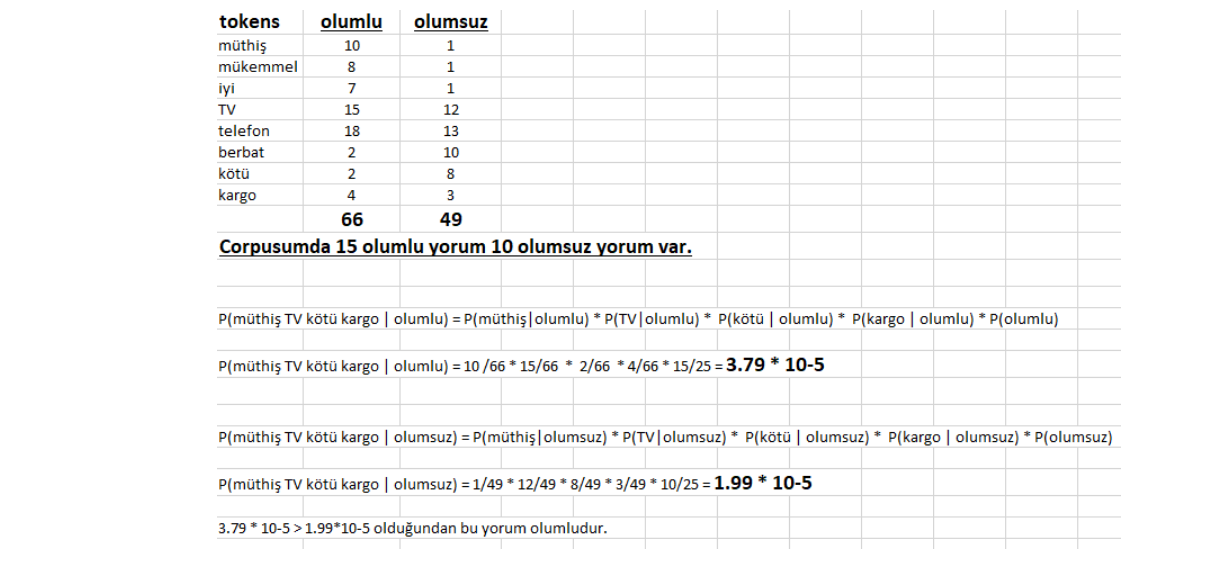

In [79]:
# Naive Bayes teoremi daha cok NLP modelleri ile kullanilir. Bayes teoremine göre çalışır
# Yorumumda "I", "don't" ve "like" tokenleri geçerken olumlu olma olasılığı 
# Yorumumda "I", "don't" ve "like"  tokenleri geçerken olumsuz olma olasılığı 
# Yorumumda "I", "don't" ve "like"  tokenleri geçerken nötr olma olasılığı 
# .. bunlara bakar hangi olasılık büyükse o sınıfa atar tokeni. "0.5" gibi bir threshold yoktur
# Örnek: P(kötü | olumsuz) : kötü tokeni geçerken olumsuz olma olasılığı # P(olumsuz) : Olumsuz yorum olma olasılığı
# .. "Müşhiş" in bir yorumu olumsuz yapma olasılığı 1/49

# NOT: alpha nın rolü(alpha=10 için): Eğer datam "harika tv kötü kargo" olsaydı --> harika kelimesi hiç geçmediği için olumlu 
# .. olma olasılığını "0"(0/66=0) a çeker) direk olasılığı 0 a çekmesin diye alpha değerini dikkate alır pay a 
# .. alpha değerini ekler paydaya da "15(olumlu yorum) * alpha" değerini ekler --> (0+10) / 66 + (15*10)  yani alpha bir 
# .. smoothness işlemi yapar yani olasılığın 0 a gitmesini engeller. Bunu o sıradaki her tokene uyguluyoruz(alttaki resim)
# Overfitting problemi varsa alpha ile oynayarak bu overfitting i giderebiliriz

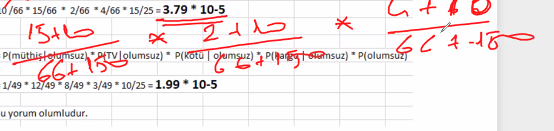

__P(A|B) -->__ A olayi gerceklestiginde B olayinin gerceklesme ihtimali nedir? Buradaki A olayi "don't like" olsun. don't like tokenleri birlikte kullanildiginda yorumun negatif olma olasiligi nedir durumuna Naive Bayes bakar. (P(don't like|negative)). Olasiliklar uzerinden calistigi icin NLP' de cok guzel sonuclar verir. Bu yuzden NLP ile kullanilmasi tavsiye edilir. 

Navie Bayes' te kullanilan 3 farkli algoritma var. Bunlardan en cok kullanilan iki tanesi : __MultinomialNB, BernoulliNB__

__MultinomialNB -->__ Daha cok multiclass datalarda tercih edilir.

__BernoulliNB -->__ Daha cok binary datalarda tercih edilir.

Dokumaninda her ikisinin de denenip hangisi iyi sonuc veriyorsa onun secilmesi onerilir(MultinomialNB, BernoulliNB)

In [80]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # BernoulliNB for binary model

Bu datada multiclass ve MultinomialNB ile daha iyi sonuc verdigi icin bununla devam edecegiz.

__alpha -->__ Mesela ilk satirda 'able' tokeni hic gecmemis (0). O zaman olasilik hesabi yaparken P(0|positive)=0 cikacak. alpha, bu tur tokenlere bir regularization islemi yapar. 'able' kelimesi gectigi zaman da corpus icindeki kullanim sikliklarina gore dusuk de olsa mutlaka bir olasilik döndürür. Bu tokene dusuk bir agirlik verilmis olur fakat bu token cumlede geciyorsa positive veya negative olma durumu ogrenilmis olur. Bu sayede Naive Bayes modellerin overfite gitmesi engellenir. alpha degeri ne kadar buyurse o kadar yuksek derecede regularization islemi uygulanir (Ridge ve Lasso' daki gibi) (Default=1)

Logistic Regression' da ci degeri, SVM' deki gama degeri kuculdukce uygulanan regularization islemi artiyordu, burda ise alpha degeri ne kadar buyurse uygulanan regularization islemi o kadar artar.

__!!!__ Eger bir overfit durumuyla karsilasilirsa yapilacak ilk islem, alpha degerini buyutmektir __!!!__

In [81]:
nb = MultinomialNB(alpha=10)
nb.fit(X_train_count,y_train)

MultinomialNB(alpha=10)

alpha=10 degeri ile train ve test datalarindaki negatif skorlarin birbirlerine yaklastigini gorduk, bu yuzden bu alpha degerini sectik (Negatif skorlar ile ilgileniyoruz). Train set ve Test set skorlari birbirine yakin,  overfitting durumu yok :

In [82]:
print("NB MODEL")
eval(nb, X_train_count, X_test_count)
# Test:  negative       0.71      0.98      0.83      1835
# Train: negative       0.72      0.98      0.83      7343

# Johnson: overfittint kontrolünü her zaman cross validation üzerinden yapın

NB MODEL
[[1793   27   15]
 [ 467  129   24]
 [ 251   16  206]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.83      1835
     neutral       0.75      0.21      0.33       620
    positive       0.84      0.44      0.57       473

    accuracy                           0.73      2928
   macro avg       0.77      0.54      0.57      2928
weighted avg       0.74      0.73      0.68      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.72      0.98      0.83      7343
     neutral       0.80      0.25      0.38      2479
    positive       0.86      0.44      0.58      1890

    accuracy                           0.74     11712
   macro avg       0.79      0.56      0.60     11712
weighted avg       0.76      0.74      0.70     11712



Negative skorlara yogunlasarak cross_validate islemi yaptik. Yukaridaki tek seferlik skorlar ile yakin skorlar elde ettik :

In [83]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

scoring = {'accuracy': make_scorer(accuracy_score),
            'precision-neg': make_scorer(precision_score, average=None, labels=["negative"]),
            'recall-neg': make_scorer(recall_score, average=None, labels = ["negative"]),
            'f1-neg': make_scorer(f1_score, average=None, labels = ["negative"])}

model = MultinomialNB(alpha=10)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# NOT: labels içerisine birden fazla sınıf yazmazsak "average=None" ın hiç bir anlamı yok
# test: validation(1 parça) , train deki train(9 parça)
# Overfitting kontrolünü yaptık
# Hem de skorların tutarlılığını kontrol ettik.
# Johnson H: Her zaman bu şekilde kontrol edin

test_accuracy          0.714482
train_accuracy         0.734138
test_precision-neg     0.704816
train_precision-neg    0.717308
test_recall-neg        0.978891
train_recall-neg       0.984293
test_f1-neg            0.819534
train_f1-neg           0.829855
dtype: float64

Dengesiz bir datasetimiz oldugu icin precision_recall ile modelin skorlarina baktik. Negative class icin modelin genel performansi %92 :

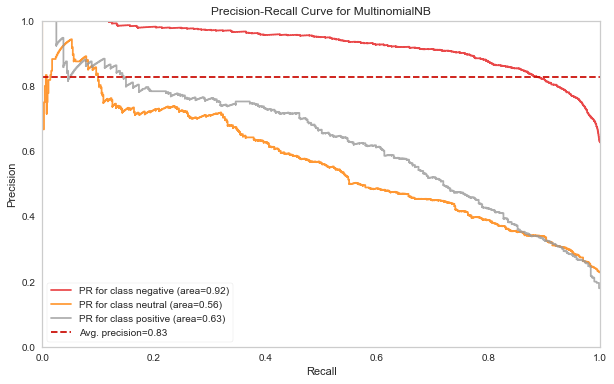

In [84]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    MultinomialNB(alpha=10),
    classes=nb.classes_,     # targettaki class' lar ile aynı isimler döndürsün diye
    per_class=True,          # Her class için ayrı ayrı çizgi çizsin
    cmap="Set1"              # renklendirme
)
viz.fit(X_train_count,y_train)  # egitim yap
viz.score(X_test_count, y_test) # skorlari al
viz.show();                     # gorsellestir
# PR for class negative(area=0.92) Benim labellarım negative labelları %92 oranında başarılı bir şekilde ayrıştırıyor

Asagida modelleri bir tabloda karsilastiracagimiz icin; negative label icin recall_score, f1 score ve gorseldeki skoru (viz.score ile) alip birer degiskene atadik :

In [85]:
y_pred = nb.predict(X_test_count)
nb_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_AP_neg = viz.score_["negative"]
# viz.score_ : 3 skoruda döndürür üstteki şekildeki(0.92, 0.56, 0.63). Burada viz.score_["negative"] ile negatifleri filtreledik sadece

## Logistic Regression

__C=1__ default degeri ile model, overfite gittigi icin bu degeri kuculttuk. Degerleri manuel olarak denedik fakat GridSearch islemi de yapilabilirdi. 

__max_iter__ yetersiz kalirsa min noktaya ulasamadigi icin 'iterasyon sayisini' artir uyarisini verir, bu yuzden 1000 verdik. 

In [86]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C = 0.02, max_iter=1000) #class_weight='balanced'
log.fit(X_train_count,y_train)
# C değerimizin büyük olmasını istemiyorduk. Overfitting varsa C değerini küçültüyoruz
# C değeri küçülürse uyguladığı regresyon kuvveti artar
# Log Reg arkada Gradient Descent kullanır. Hatanın min e inmesi için iterasyonu kullanır. iterasyon yetersizse bu arttıralır
# .. uyarı vermeyene kadar arttırabilirsiniz
# class_weight='balanced' .. negative in eğitim için sayısı yeterli, skorlarda iyi o yüzden class_weight='balanced' yapmadık

LogisticRegression(C=0.02, max_iter=1000)

Train ve test set skorlari birbirine yakin, overfit durumu yok :

In [87]:
print("LOG MODEL")
eval(log, X_train_count, X_test_count)
# negative       0.76      0.96      0.85      1835
# negative       0.77      0.97      0.86      7343

# Johnson H: Müşteriye bu skorlar verilir mi verilmez mi? Bunlar nasıl yorumlanır? Overfitting var mı? En optimal skorlar nedir?
# .. En iyi skorları almaya çalışmamalıyız. Önemli olan bu soruların cevaplarını doğru verebiliyor muyuz? Yorum yapabiliyor muyuz?
# .. Sonuç olarak: Metriklerin yorumlanması en önemli kısımdır. Mesele kodları çalıştırmak değildir. Müşteriye verilen
# .. skorlar optimal değilse yazdığınız kodların, aldığınız skorların hiç bir anlamı yok

LOG MODEL
[[1760   39   36]
 [ 365  212   43]
 [ 177   47  249]]
Test_Set
              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      1835
     neutral       0.71      0.34      0.46       620
    positive       0.76      0.53      0.62       473

    accuracy                           0.76      2928
   macro avg       0.75      0.61      0.64      2928
weighted avg       0.75      0.76      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.77      0.97      0.86      7343
     neutral       0.76      0.40      0.53      2479
    positive       0.79      0.51      0.62      1890

    accuracy                           0.77     11712
   macro avg       0.77      0.63      0.67     11712
weighted avg       0.77      0.77      0.75     11712



CrossValidate skorlari tek seferlik skorlarla uyumlu :

In [88]:
model = LogisticRegression(C = 0.02, max_iter=1000)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# Not(ÖNEMLI): "df_scores" ile  : validation ve train setindeki bütün skorları siz yine de bir gözden geçirin(Burada ortalama aldık sadece(df_scores.mean()[2:]))
# Ancak skorlar yakın olmayabilir cv yaparken bu sefer müşteriye ben genelleme yapıyorum dersiniz
# .. sonra müşteri farklı skorlar alabilir. Bunun kontrolünü mutlaka yapın(Alttaki 2 resme bkz.)
# Yani Skorları yakın olan modeller arasında seçim yapmakta zorlanılıyorsa
# .. Validation ve train seti arasındaki farkların en düşük olduğu modeli almamız daha doğru

test_accuracy          0.745646
train_accuracy         0.765113
test_precision-neg     0.747594
train_precision-neg    0.761561
test_recall-neg        0.963365
train_recall-neg       0.970584
test_f1-neg            0.841856
train_f1-neg           0.853460
dtype: float64

####  Skorlar yakınken(Cv de)(5 skorda yakın birbirine - Precision: 0.76,0.8,0.77,0.75,0.75, yada recall için 0.97,0.96,0.94,... )
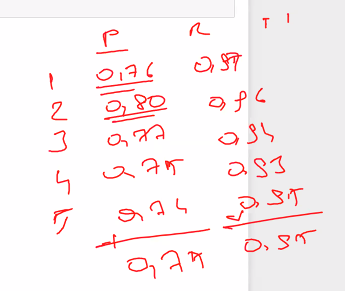

##### Skorlar yakın değilken(Cv de)(Yani genelleme yapamıyor)
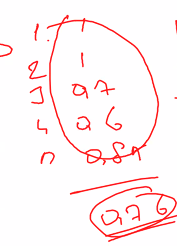

In [89]:
# 13.10.2022 ders sonu

PrecisionRecallCurve' de yukaridakine benzer bir skor elde ettik :

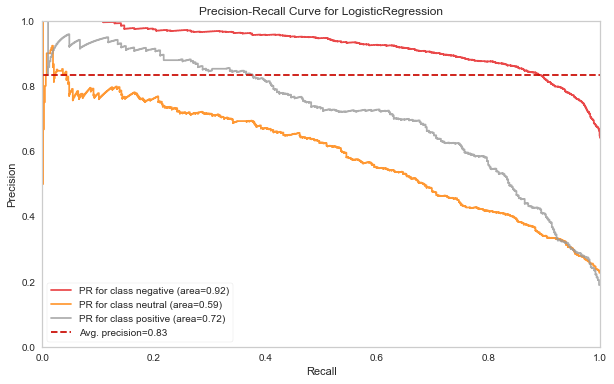

In [90]:
viz = PrecisionRecallCurve(
    LogisticRegression(C = 0.02, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();
# Modelim Negative classları diğer class lardan ayırmada %92 başarılı
# Modelleri karşılaştırma yaparken öncelikle bakacağımız precision,recall, f1 score lardır 
# .. sonra precision-recall curve(modelin genel performansı) e bakıyoruz

Karsilastirma icin skorlari degiskenlere atadik :

In [91]:
y_pred = log.predict(X_test_count)
log_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_AP_neg = viz.score_["negative"]
# Labels da tek değer verdik(negative) o yüzden average= 'macro', average='micro' ya da average='weigted'
# .. yazsanız da skorlarda değişiklik olmaz. Eğer labels a 1 den fazla değer yazarsak average ı değiştirdiğimizde
# .. skorlar değişir

Modeldeki negative skorlarla ilgileniyoruz fakat yine de class_weight='balanced' dedik ve neutral ve positive skorlar da yukseldi. neutral ve positive yorumlar da onemli ise class_weight='balanced' mutlaka kullanilmali, cunku dengesiz bir datasetimiz var :

In [92]:
log = LogisticRegression(C = 0.02, max_iter=1000, class_weight='balanced')
log.fit(X_train_count,y_train)
# class_weight='balanced' yaptığımız zaman inbalanced olan sınıfların skorları iyileşirken fazla olan(negative) sınıfın
# .. skorları düşecektir(GENELDE)

LogisticRegression(C=0.02, class_weight='balanced', max_iter=1000)

In [93]:
print("LOG MODEL BALANCED")
eval(log, X_train_count, X_test_count)

LOG MODEL BALANCED
[[1304  433   98]
 [  98  447   75]
 [  34   96  343]]
Test_Set
              precision    recall  f1-score   support

    negative       0.91      0.71      0.80      1835
     neutral       0.46      0.72      0.56       620
    positive       0.66      0.73      0.69       473

    accuracy                           0.72      2928
   macro avg       0.68      0.72      0.68      2928
weighted avg       0.77      0.72      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.74      0.82      7343
     neutral       0.51      0.78      0.62      2479
    positive       0.67      0.75      0.71      1890

    accuracy                           0.75     11712
   macro avg       0.70      0.75      0.72     11712
weighted avg       0.80      0.75      0.76     11712



## SVM

In [94]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01) # Linear i tercih ettik default yerine. Default biraz maliyetli idi
svc.fit(X_train_count,y_train)

LinearSVC(C=0.01)

__C=1__ default degeri ile model overfite gittigi icin bu degeri asama asama kuculterek en iyi skoru aldigimiz 0.01' i sectik. 

In [95]:
print("SVC MODEL")
eval(svc, X_train_count, X_test_count)
# Bazı data scientist ler başarıyı sadece recall üzerinden değerlendirir ama mutlaka precision ı da değerlendirmek gerekir
# Recall=1, precision=0,1 olursa. recall=100 hastanın hepsini bulmuş, precision 1000 tanesinin 100 hepsine hasta(1) demiş. Bu bir başarı değildir
# .. Müşteri o 1000 kişi için tekrar testler yapmak zorunda kalacak(Müşteriye maliyet)
# Evet recall u yüksek elde etmeye çalışıyoruz ama precision değeri de önemli. 
# .. Precision daki Yüzde 1 lik değişmeler bile müşteri için maliyet açısından değerli olabilir

# precision benim için ne zaman önemli
# Modelin hasta dediği 100 de 100 ü de hasta(Precision = 1) olsun derse müşteri precision ı kullanırız
# .. Yani müşteri modele hastaları sokunca gerçekten hasta olanları bulur
# recall un mantığı ise yine bütün kanser hastalarını bulayım ama min tahminle bulayım(maliyeti daraltayım)
# Modellerde skorları((test ve train de)) aynı ise(Precision, recall vs), hangisi(hangi model) daha iyi genelleyebiliyor(hangi modelin train,test skorları en yakınsa) o modeli kullanırız

SVC MODEL
[[1710   81   44]
 [ 291  279   50]
 [ 124   50  299]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1835
     neutral       0.68      0.45      0.54       620
    positive       0.76      0.63      0.69       473

    accuracy                           0.78      2928
   macro avg       0.75      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.83      0.95      0.89      7343
     neutral       0.76      0.55      0.64      2479
    positive       0.80      0.63      0.70      1890

    accuracy                           0.82     11712
   macro avg       0.80      0.71      0.74     11712
weighted avg       0.81      0.82      0.81     11712



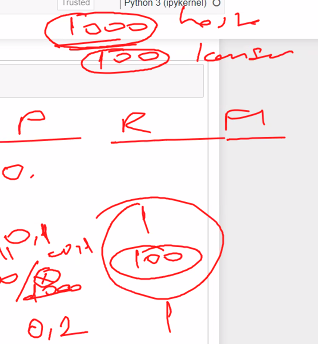

Tek seferlik skorlar ile CrossValidate sonucu alinan skorlar dengeli :

In [96]:
model = LinearSVC(C=0.01)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10,return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.777494
train_accuracy         0.816390
test_precision-neg     0.799702
train_precision-neg    0.828608
test_recall-neg        0.939396
train_recall-neg       0.956996
test_f1-neg            0.863922
train_f1-neg           0.888186
dtype: float64

Modelin genel performansi onceki modeller ile cok yakin :

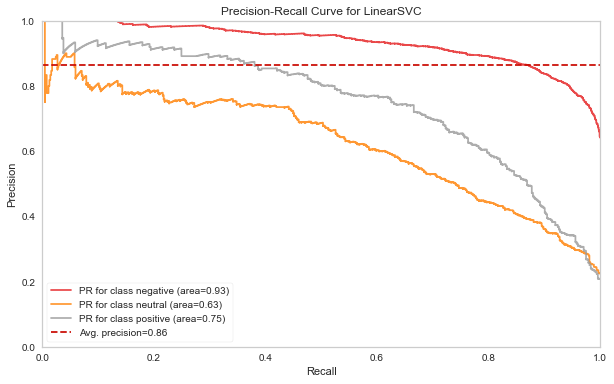

In [97]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.01),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

Karsilastirma icin skorlari degiskenlere atadik :

In [98]:
y_pred = svc.predict(X_test_count)
svc_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_AP_neg = viz.score_["negative"]

## KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_count,y_train)

KNeighborsClassifier(n_neighbors=7)

KNN icin Elbow metodu ile egitim cok uzun surecegi icin ve skorlar da cok kotu ciktigi icin birkac n_neighbors degeri deneyerek n_neighbors=7' de karar kildik ve skorlarimizi aldik :

In [100]:
print("KNN MODEL")
eval(knn, X_train_count, X_test_count)

KNN MODEL
[[916 834  85]
 [107 451  62]
 [ 51 169 253]]
Test_Set
              precision    recall  f1-score   support

    negative       0.85      0.50      0.63      1835
     neutral       0.31      0.73      0.43       620
    positive       0.63      0.53      0.58       473

    accuracy                           0.55      2928
   macro avg       0.60      0.59      0.55      2928
weighted avg       0.70      0.55      0.58      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.90      0.62      0.74      7343
     neutral       0.40      0.82      0.53      2479
    positive       0.70      0.56      0.62      1890

    accuracy                           0.65     11712
   macro avg       0.67      0.67      0.63     11712
weighted avg       0.76      0.65      0.68     11712



CrossValidate sonucu alinan skorlar da oldukca kotu :

In [101]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10,return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.528603
train_accuracy         0.646346
test_precision-neg     0.843510
train_precision-neg    0.902867
test_recall-neg        0.463299
train_recall-neg       0.610892
test_f1-neg            0.597722
train_f1-neg           0.728680
dtype: float64

KNN modelin genel performansi onceki modellerden oldukca dusuk cikti :

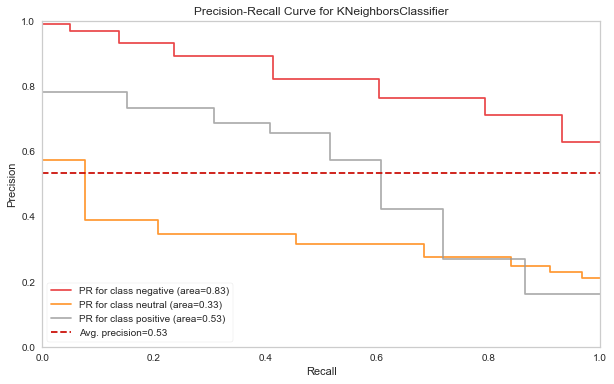

In [102]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();
# Buradaki skor 0,83 ancak bunu direk atalım demeyebiliriz. Yani overfit i giderirsek bu skorlar
# .. yükselebilir o yüzden bizim önceliğimiz buradaki 0,83 değil önce precision,recall, f1 skorlarımızdır
# .. oradaki overfit i engellersek buradaki skor da yükselecektir

Karsilastirma icin aldigimiz skorlari degiskenlere atadik :

In [103]:
y_pred = knn.predict(X_test_count)
knn_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_AP_neg = viz.score_["negative"]

## Random Forest

In [104]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1) # class_weight="balanced"
rf.fit(X_train_count, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

GridSearch islemi yapmadik. RF modellerde ilk oynamamiz gereken parametre olan max_depth ile oynadik. 100, 200 gibi degerler verdigimizde modeli overfitten kurtaramadik; degerler kuculdukce negative skorlar icin overfitin engellendigini gorduk. En iyi skoru 40 degerinde aldik :

In [105]:
print("RF MODEL")
eval(rf, X_train_count, X_test_count)
# Ağaç yöntemlerinde Overfit i engellemek için önceliğimiz max_depth dir. 2. önemli parametre ağaç sayısıdır(100 yazan yer/parametre)
#  negative       0.71      0.98      0.82      1835
#  negative       0.74      1.00      0.85      7343

RF MODEL
[[1798   11   26]
 [ 522   60   38]
 [ 220    6  247]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.82      1835
     neutral       0.78      0.10      0.17       620
    positive       0.79      0.52      0.63       473

    accuracy                           0.72      2928
   macro avg       0.76      0.53      0.54      2928
weighted avg       0.74      0.72      0.65      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.74      1.00      0.85      7343
     neutral       0.97      0.20      0.34      2479
    positive       0.92      0.63      0.75      1890

    accuracy                           0.77     11712
   macro avg       0.88      0.61      0.64     11712
weighted avg       0.82      0.77      0.72     11712



Tek seferlik skorlarimiz ile CrossValidate sonucu aldigimiz skorlar tutarli :

In [106]:
model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10,return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.709870
train_accuracy         0.774030
test_precision-neg     0.698851
train_precision-neg    0.742443
test_recall-neg        0.984065
train_recall-neg       0.997428
test_f1-neg            0.817284
train_f1-neg           0.851251
dtype: float64

Negative class icin modelin genel performansi yuksek :

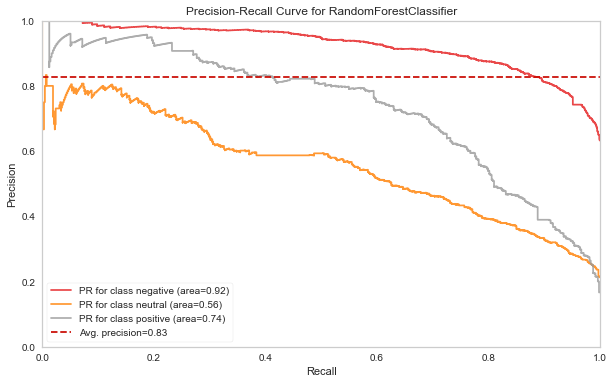

In [107]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

Karsilastirma icin skorlari degiskenlere atadik :

In [108]:
y_pred = rf.predict(X_test_count)
rf_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_AP_neg = viz.score_["negative"]

In [109]:
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)
# Bir de balanced ile deneyelim

RandomForestClassifier(class_weight='balanced', max_depth=40, n_jobs=-1,
                       random_state=42)

RF modele bir de class_weight='balanced' ile baktik. positive' de train ve test setleri arasinda yuksek fark var. Positive skorlara bakacak olsaydik, yukaridaki parametreler ile denemeler yapip modeli overfit durumundan kurtarmamiz gerekirdi :

In [110]:
print("RF MODEL BALANCED")
eval(rf, X_train_count, X_test_count)
# Buradaki overfit i gidermek için max_depth le oynayabiliriz ama bizim için önemli olan "balanced"
# .. sonucu değil.

RF MODEL BALANCED
[[1456  306   73]
 [ 154  401   65]
 [  53   99  321]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.79      0.83      1835
     neutral       0.50      0.65      0.56       620
    positive       0.70      0.68      0.69       473

    accuracy                           0.74      2928
   macro avg       0.69      0.71      0.69      2928
weighted avg       0.77      0.74      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.97      0.85      0.91      7343
     neutral       0.64      0.90      0.75      2479
    positive       0.87      0.82      0.85      1890

    accuracy                           0.86     11712
   macro avg       0.83      0.86      0.83     11712
weighted avg       0.89      0.86      0.86     11712



## Ada Boost

In [111]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

Ada Boost yerine XGBoost da tercih edilebilirdi. n_estimators= 500 ile train ve test skorlarinin birbirine yaklastigini gordugumuz icin bu degeri sectik.

In [112]:
print("Ada MODEL")
eval(ada, X_train_count, X_test_count)
# precision ve recall skorları müşteri dengeli olsun isterse Bu modeli kullanabilirsiniz
# negative       0.85      0.85      0.85      1835
# negative       0.87      0.88      0.88      7343

Ada MODEL
[[1563  197   75]
 [ 197  343   80]
 [  86   78  309]]
Test_Set
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      1835
     neutral       0.56      0.55      0.55       620
    positive       0.67      0.65      0.66       473

    accuracy                           0.76      2928
   macro avg       0.69      0.69      0.69      2928
weighted avg       0.76      0.76      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.88      0.88      7343
     neutral       0.61      0.62      0.61      2479
    positive       0.78      0.71      0.74      1890

    accuracy                           0.80     11712
   macro avg       0.75      0.74      0.74     11712
weighted avg       0.80      0.80      0.80     11712



Tek seferlik skorlar ile CrossValidate sonucu alinan skorlar birbirleriyle tutarli :

In [113]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10,return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.758624
train_accuracy         0.802226
test_precision-neg     0.843627
train_precision-neg    0.866649
test_recall-neg        0.856325
train_recall-neg       0.883774
test_f1-neg            0.849898
train_f1-neg           0.875122
dtype: float64

Negative class icin modelin genel performansi yuksek :

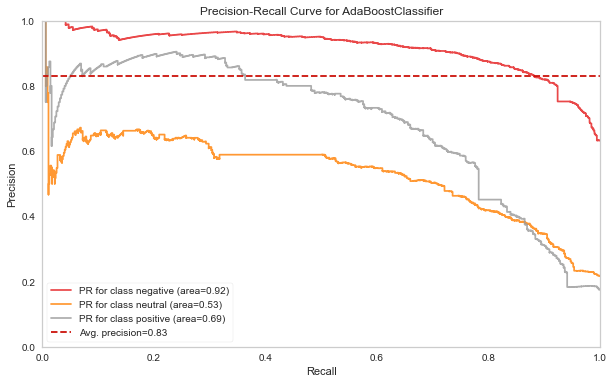

In [114]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

Karsilastirma icin skorlari degiskenlere atadik :

In [115]:
y_pred = ada.predict(X_test_count)
ada_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_AP_neg = viz.score_["negative"]

Yukaridaki islemler ile CountVectorizer kismini tamamlamis olduk, TF-IDF kismina gececegiz :

In [ ]:
# ÖNEMLİ HATIRLATMA: Johnson H: Overfitting kontrolünü her zaman Cross validation da aldığımız skorların birbirine yakın olup olmamasına 
# .. bakarak yapıyoruz.(Yani Alttaki kod a göre)
"""
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10,return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# Bu kodun çıktısındaki ;
# .. test accuracy/f1/recall= "validation" skorlarının ortalama sonucu(10 değerin ortalaması), 
# .. train test accuracy/f1/recall= "train içindeki train" skorlarının ortalama sonucu(10 değerin ortalaması)
"""
# Yani "eval(ada, X_train_count, X_test_count)" kodunda aldığımız test ve train sonuçlarının birbirine
# .. yakın olup olmamasına bakarak DEĞİL!!

# Dünkü cv kısmında açıklamadaki cümleler düşük ve karışık olmuş olabilir. Hocanın dediğini biraz data detaylı yazdık

##### Genellemeyi doğru yapabilen cv ye örnek(Bu resmin çıktı halini "df_scores" yazdırarak alabiliriz. "df_scores.mean()[2:]" yazdığımız için ortalama alınmış sonuçları görüyoruz)
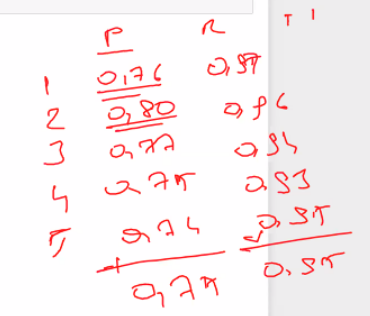

## TF-IDF

Yukarida CountVectorizer ile text' i sayisal verilere donusturup tum modeller icin skorlar aldik. Simdi ise sayisal verilere donusturme islemini TF-IDF ile yapacagiz ve tum modeller icin yine skorlar alacagiz. 

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

preprocessor=cleaning diyerek create ettigimiz fonksiyon ile cleaning islemini yapmis olduk. (min_df=3 kullanmak idealdir.)

In [117]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=cleaning, min_df=3)
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)
# min_df=3 = Benim corpusumda  1 veya 2 yorumda geçen tokenleri ignore et demek
# DIKKAT bu şu demek DEĞİL: Benim corpusumda 1 veya 2 kere geçen tokenleri ignore et.. 

# class chat soru: Hocam datadan 1 veya 2 gibi ya da belli bir değerin altında frekansa sahip olan kelimeleri silmeli miyiz?
# Johnson H: O da yöntemlerden birtanesi ama bizim min_df ile yaptığımız zaten datada 1 veya 2 defa geçenleride siliyor. Yani min_df daha geniş kapsamlı bir işlem yapıyor

In [118]:
X_train_tf_idf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32545156, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [119]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names_out())
# get_feature_names_out(): fit işleminin uygulandığı train setindeki unique tokenleri isimleri

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abt,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,accordingly,...,yea,yeah,year,yell,yelled,yelling,yep,yes,yest,yesterday,yet,yo,york,youd,youll,young,youre,youve,yr,yuma,yup,yvr,yyz,zero,zone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11707,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11708,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11709,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Comparisons  TF-IDF

## Naive Bayes

MultinomialNB() icindeki alpha parametresi ile oynamadik cunku default deger olan 1 ile negative class icin en iyi skoru verdi :

In [120]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
nb = MultinomialNB()
nb.fit(X_train_tf_idf,y_train)

MultinomialNB()

Modelde skorlarımız yakın

In [121]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

NB MODEL
[[1802   25    8]
 [ 426  172   22]
 [ 248   31  194]]
Test_Set
              precision    recall  f1-score   support

    negative       0.73      0.98      0.84      1835
     neutral       0.75      0.28      0.41       620
    positive       0.87      0.41      0.56       473

    accuracy                           0.74      2928
   macro avg       0.78      0.56      0.60      2928
weighted avg       0.76      0.74      0.70      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.75      0.99      0.85      7343
     neutral       0.84      0.35      0.50      2479
    positive       0.91      0.51      0.65      1890

    accuracy                           0.78     11712
   macro avg       0.84      0.62      0.67     11712
weighted avg       0.80      0.78      0.75     11712



CrossValidate skorlari tek seferlik skorlar ile tutarli , overfitting yok:

In [122]:
model = MultinomialNB()
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10,return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.731643
train_accuracy         0.774277
test_precision-neg     0.721593
train_precision-neg    0.751007
test_recall-neg        0.978890
train_recall-neg       0.988818
test_f1-neg            0.830756
train_f1-neg           0.853659
dtype: float64

Modelin genel performansi yuksek :

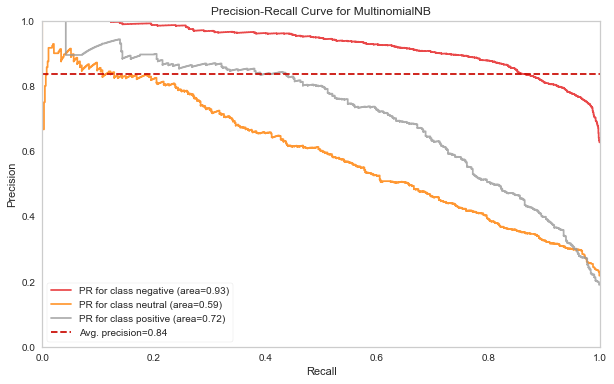

In [123]:
viz = PrecisionRecallCurve(
    MultinomialNB(),
    classes=nb.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [124]:
y_pred = nb.predict(X_test_tf_idf)
nb_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_AP_neg = viz.score_["negative"]

## Logistic Regression

In [125]:
# 2. ders
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=0.4, max_iter=1000)
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, max_iter=1000)

C=0.4 degeri ile model overfitten kurtuldugu icin bu degeri sectik. 

In [126]:
print("LOG MODEL")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL
[[1757   51   27]
 [ 332  256   32]
 [ 144   47  282]]
Test_Set
              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      1835
     neutral       0.72      0.41      0.53       620
    positive       0.83      0.60      0.69       473

    accuracy                           0.78      2928
   macro avg       0.78      0.66      0.69      2928
weighted avg       0.78      0.78      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.82      0.97      0.89      7343
     neutral       0.82      0.53      0.64      2479
    positive       0.87      0.62      0.73      1890

    accuracy                           0.82     11712
   macro avg       0.84      0.71      0.75     11712
weighted avg       0.83      0.82      0.81     11712



Tek seferlik skorlar ile CrossValidate sonucu alinan skorlar tutarli :

In [127]:
model = LogisticRegression(C=0.4, max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.771432
train_accuracy         0.821124
test_precision-neg     0.776195
train_precision-neg    0.813107
test_recall-neg        0.960370
train_recall-neg       0.976743
test_f1-neg            0.858497
train_f1-neg           0.887444
dtype: float64

Negative class icin modelin performansi yuksek :

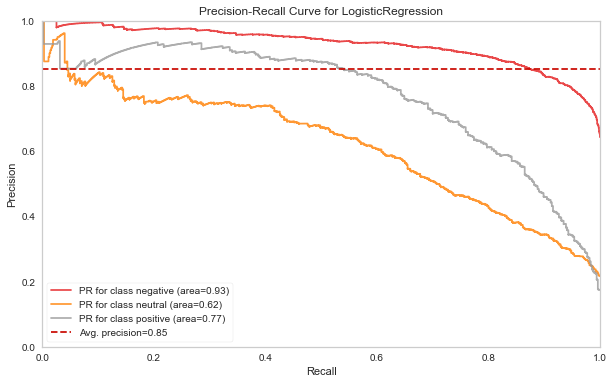

In [128]:
viz = PrecisionRecallCurve(
    LogisticRegression(C=0.4, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

Karsilastirma icin skorlari degiskenlere atadik :

In [129]:
y_pred = log.predict(X_test_tf_idf)
log_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_AP_neg = viz.score_["negative"]

In [130]:
log = LogisticRegression(C=0.4, max_iter=1000, class_weight="balanced")
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, class_weight='balanced', max_iter=1000)

class_weight='balanced' ile skorlarimiza tekrar baktik. Positive class' in train ve test skorlari arasinda fark var, bu farki azaltmak icin parametreler ile oynamak gerekir fakat bizim icin onemli class Negative class' i oldugu icin oynamayacagiz :

In [131]:
print("LOG MODEL BALANCED")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL BALANCED
[[1431  305   99]
 [ 121  427   72]
 [  39   71  363]]
Test_Set
              precision    recall  f1-score   support

    negative       0.90      0.78      0.84      1835
     neutral       0.53      0.69      0.60       620
    positive       0.68      0.77      0.72       473

    accuracy                           0.76      2928
   macro avg       0.70      0.75      0.72      2928
weighted avg       0.79      0.76      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87      7343
     neutral       0.61      0.80      0.69      2479
    positive       0.74      0.84      0.79      1890

    accuracy                           0.81     11712
   macro avg       0.76      0.82      0.78     11712
weighted avg       0.84      0.81      0.82     11712



## SVM

In [132]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.1)
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=0.1)

SVM modelde C=0.1 ile negative class' taki overfitting' i giderebildik. 

In [133]:
print("SVC MODEL")
eval(svc, X_train_tf_idf, X_test_tf_idf)

SVC MODEL
[[1738   63   34]
 [ 312  263   45]
 [ 124   43  306]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1835
     neutral       0.71      0.42      0.53       620
    positive       0.79      0.65      0.71       473

    accuracy                           0.79      2928
   macro avg       0.77      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      7343
     neutral       0.83      0.56      0.67      2479
    positive       0.87      0.68      0.76      1890

    accuracy                           0.84     11712
   macro avg       0.84      0.74      0.78     11712
weighted avg       0.84      0.84      0.83     11712



Tek seferlik skorlar ile CrossValidate sonucu alinan skorlar birbirine yakin :

In [134]:
model = LinearSVC(C=0.1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.782019
train_accuracy         0.837963
test_precision-neg     0.790376
train_precision-neg    0.832860
test_recall-neg        0.957101
train_recall-neg       0.974866
test_f1-neg            0.865746
train_f1-neg           0.898282
dtype: float64

Negative class' a ait genel performans yuksek :

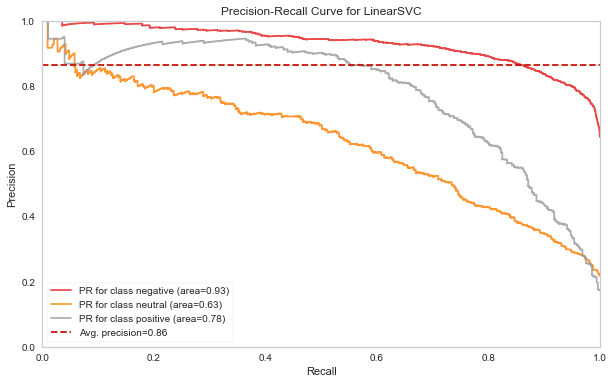

In [135]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.1),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

Karsilastirma yapmak uzere skorlari degiskenlere atadik :

In [136]:
y_pred = svc.predict(X_test_tf_idf)
svc_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_AP_neg = viz.score_["negative"]

## KNN

In [137]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tf_idf,y_train)

KNeighborsClassifier(n_neighbors=7)

KNN modeli skorlari onceki gibi cok kotu oldugu icin parametreler ile oynamanin da bir anlami yok :

In [138]:
print("KNN MODEL")
eval(knn, X_train_tf_idf, X_test_tf_idf)

KNN MODEL
[[ 278 1546   11]
 [  73  532   15]
 [  41  339   93]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.15      0.25      1835
     neutral       0.22      0.86      0.35       620
    positive       0.78      0.20      0.31       473

    accuracy                           0.31      2928
   macro avg       0.57      0.40      0.30      2928
weighted avg       0.62      0.31      0.28      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.29      0.44      7343
     neutral       0.26      0.91      0.40      2479
    positive       0.83      0.24      0.38      1890

    accuracy                           0.41     11712
   macro avg       0.65      0.48      0.41     11712
weighted avg       0.74      0.41      0.42     11712



In [139]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.300204
train_accuracy         0.407844
test_precision-neg     0.709476
train_precision-neg    0.863610
test_recall-neg        0.139039
train_recall-neg       0.281674
test_f1-neg            0.232049
train_f1-neg           0.423972
dtype: float64

Modelin genel performansi cok dusuk :

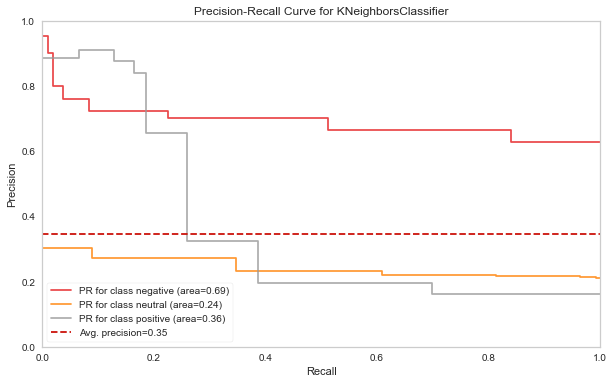

In [140]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [141]:
y_pred = knn.predict(X_test_tf_idf)
knn_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_AP_neg = viz.score_["negative"]

## RandomForest

In [142]:
rf = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

Parametreler ile oynayarak en iyi skoru aldigimiz parametreleri sectik.

In [143]:
print("RF MODEL")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL
[[1805   10   20]
 [ 533   52   35]
 [ 243    6  224]]
Test_Set
              precision    recall  f1-score   support

    negative       0.70      0.98      0.82      1835
     neutral       0.76      0.08      0.15       620
    positive       0.80      0.47      0.60       473

    accuracy                           0.71      2928
   macro avg       0.76      0.51      0.52      2928
weighted avg       0.73      0.71      0.64      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.73      1.00      0.84      7343
     neutral       0.98      0.21      0.34      2479
    positive       0.94      0.58      0.72      1890

    accuracy                           0.76     11712
   macro avg       0.88      0.60      0.64     11712
weighted avg       0.82      0.76      0.72     11712



Tek seferlik skorlar ile CrossValidate sonucu alinan skorlar birbirine yakin :

In [144]:
model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.706967
train_accuracy         0.766308
test_precision-neg     0.693891
train_precision-neg    0.733746
test_recall-neg        0.988016
train_recall-neg       0.998230
test_f1-neg            0.815224
train_f1-neg           0.845792
dtype: float64

Negative class' a ait genel performans yuksek :

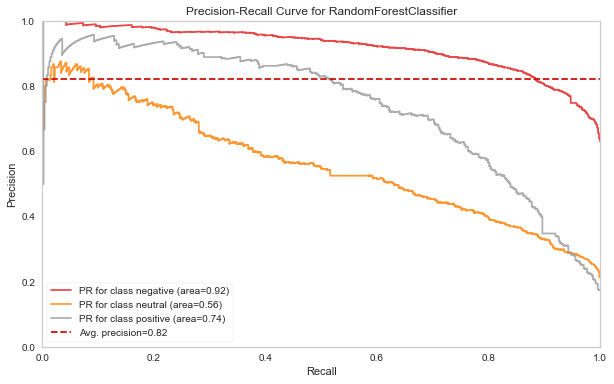

In [145]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [146]:
y_pred = rf.predict(X_test_tf_idf)
rf_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_AP_neg = viz.score_["negative"]

In [147]:
rf = RandomForestClassifier(100, max_depth=15, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

class_weight="balanced" secildiginde positive skorlar birbirine biraz daha yaklasti :

In [148]:
print("RF MODEL BALANCED")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL BALANCED
[[1356  384   95]
 [ 131  422   67]
 [  46  108  319]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.74      0.81      1835
     neutral       0.46      0.68      0.55       620
    positive       0.66      0.67      0.67       473

    accuracy                           0.72      2928
   macro avg       0.67      0.70      0.67      2928
weighted avg       0.76      0.72      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84      7343
     neutral       0.52      0.80      0.63      2479
    positive       0.75      0.72      0.73      1890

    accuracy                           0.77     11712
   macro avg       0.73      0.76      0.73     11712
weighted avg       0.81      0.77      0.78     11712



## Ada Boost

In [149]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

Negative class' lar icin en dengeli skoru AdaBoost modelde aldik, precision ve recall skorlari birbirlerine cok yakin. Musteri dengeli bir skor istediginde bu model sunulabilir :

In [150]:
print("Ada MODEL")
eval(ada, X_train_tf_idf, X_test_tf_idf)

Ada MODEL
[[1536  227   72]
 [ 223  337   60]
 [  99   74  300]]
Test_Set
              precision    recall  f1-score   support

    negative       0.83      0.84      0.83      1835
     neutral       0.53      0.54      0.54       620
    positive       0.69      0.63      0.66       473

    accuracy                           0.74      2928
   macro avg       0.68      0.67      0.68      2928
weighted avg       0.74      0.74      0.74      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      7343
     neutral       0.61      0.62      0.62      2479
    positive       0.83      0.72      0.77      1890

    accuracy                           0.80     11712
   macro avg       0.76      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



Tek seferlik skorlar ile CrossValidate sonucu alinan skorlar birbirine yakin :

In [151]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10,return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.736937
train_accuracy         0.796239
test_precision-neg     0.821348
train_precision-neg    0.851315
test_recall-neg        0.843115
train_recall-neg       0.873969
test_f1-neg            0.832032
train_f1-neg           0.862484
dtype: float64

precision ve recall degerleri diger modellere gore daha dusuk ciktigi icin genel performans da %90 cikmis :

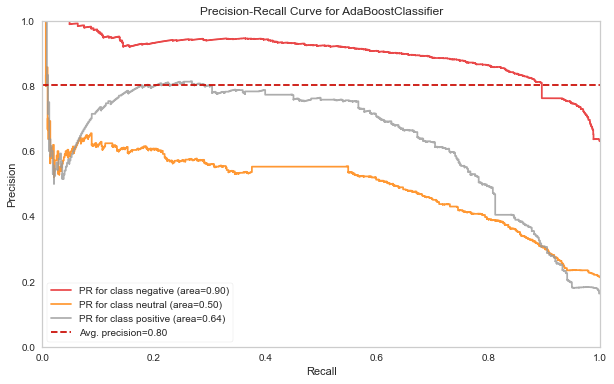

In [152]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [153]:
y_pred = ada.predict(X_test_tf_idf)
ada_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_AP_neg = viz.score_["negative"]

## Compare Scoring

Tum modellerden elde ettigimiz skorlari kiyaslamak amaciyla bir fonksiyon create ettik.

__compare__ degiskeni icine olusturdugumuz tum model isimlerini tanimladik. Bununla birlikte yukarida negative class' i icin aldigimiz tum f1 score, recall score ve precision recal score' lari da tanimladik. (recall ve f1 score, precision hakkinda da inside sagladigi icin onu yazmadik)

__nb_count_f1_neg[0] :__ Skorlari array' den kurtarmak icin [0] indexlemesini yapiyoruz.

Tanimladigimiz fonksiyon ile 3 ayri grafik elde ettik; tum modeller icin ilk grafik recall, ikinci grafik f1 score, ucuncu grafik ise precision recall skorlarini temsil ediyor.

recall grafiginde en yuksek skoru RF modeli verdi.

f1 score grafiginde yuksek skorlari SVM modelleri verdi fakat LogReg_tfidf ile de arasinda cok fazla bir fark yok. LogReg_tfidf' in recall skoru da %95. RF model recall grafiginde en yuksek skoru vermisti fakat f1 grafiginde skorlari dusuk.  Hem recall hem f1 skorunun yuksek olmasini, bununla birlikte modelin genel performansinin da yuksek olmasini istiyoruz.

Hem hizli calistigi icin hem de f1 skoru yuksek oldugu icin LogReg_tfidf secmek daha mantikli. 

LogReg_tfidf' in genel performansina baktigimizda %92, en yuksek skor ile arasinda cok fazla bir fark yok. Model olarak __LogReg_tfidf'__ i secmeye karar verdik.

In [156]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "KNN_count", "Random Forest_count", 
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", "KNN_tfidf", 
                                  "Random Forest_tfidf", "AdaBoost_tfidf"],
                        
                        "F1_Score_Negative": [nb_count_f1_neg[0], log_count_f1_neg[0], svc_count_f1_neg[0], knn_count_f1_neg[0],
                                             rf_count_f1_neg[0], ada_count_f1_neg[0], nb_tfidf_f1_neg[0], log_tfidf_f1_neg[0],
                                             svc_tfidf_f1_neg[0], knn_tfidf_f1_neg[0], rf_tfidf_f1_neg[0], ada_tfidf_f1_neg[0]],
                        
                        "Recall_Score_Negative": [nb_count_rec_neg[0], log_count_rec_neg[0], svc_count_rec_neg[0], 
                                                  knn_count_rec_neg[0], rf_count_rec_neg[0], ada_count_rec_neg[0], 
                                                  nb_tfidf_rec_neg[0], log_tfidf_rec_neg[0], svc_tfidf_rec_neg[0], 
                                                  knn_tfidf_rec_neg[0], rf_tfidf_rec_neg[0], ada_tfidf_rec_neg[0]],
                        
                        "Precision_Recall_Score_Negative": [nb_AP_neg, log_AP_neg, svc_AP_neg, knn_AP_neg, rf_AP_neg,
                                                          ada_AP_neg, nb_tfidf_AP_neg, log_tfidf_AP_neg, svc_tfidf_AP_neg,
                                                           knn_tfidf_AP_neg, rf_tfidf_AP_neg, ada_tfidf_AP_neg]})

compare
# Aşağıdaki görselleri elde etmek için dict oluşturduk
# nb_count_f1_neg[0] : Sadece f1 Skorlari array' formatında geliyor ve bu nu arrayden kurtarıyorum
# .. ve görsellerde aldığım skorların yanlış olmaması için yapıyoruz

,Model,F1_Score_Negative,Recall_Score_Negative,Precision_Recall_Score_Negative
0,NaiveBayes_count,0.825127,0.977112,0.924854
1,LogReg_count,0.850858,0.959128,0.922123
2,SVM_count,0.863636,0.931880,0.932461
3,KNN_count,0.629770,0.499183,0.826211
4,Random Forest_count,0.821943,0.979837,0.923219
5,AdaBoost_count,0.849226,0.851771,0.916030
6,NaiveBayes_tfidf,0.836001,0.982016,0.925300
7,LogReg_tfidf,0.863815,0.957493,0.926618
8,SVM_tfidf,0.867049,0.947139,0.930124
9,KNN_tfidf,0.249663,0.151499,0.689384


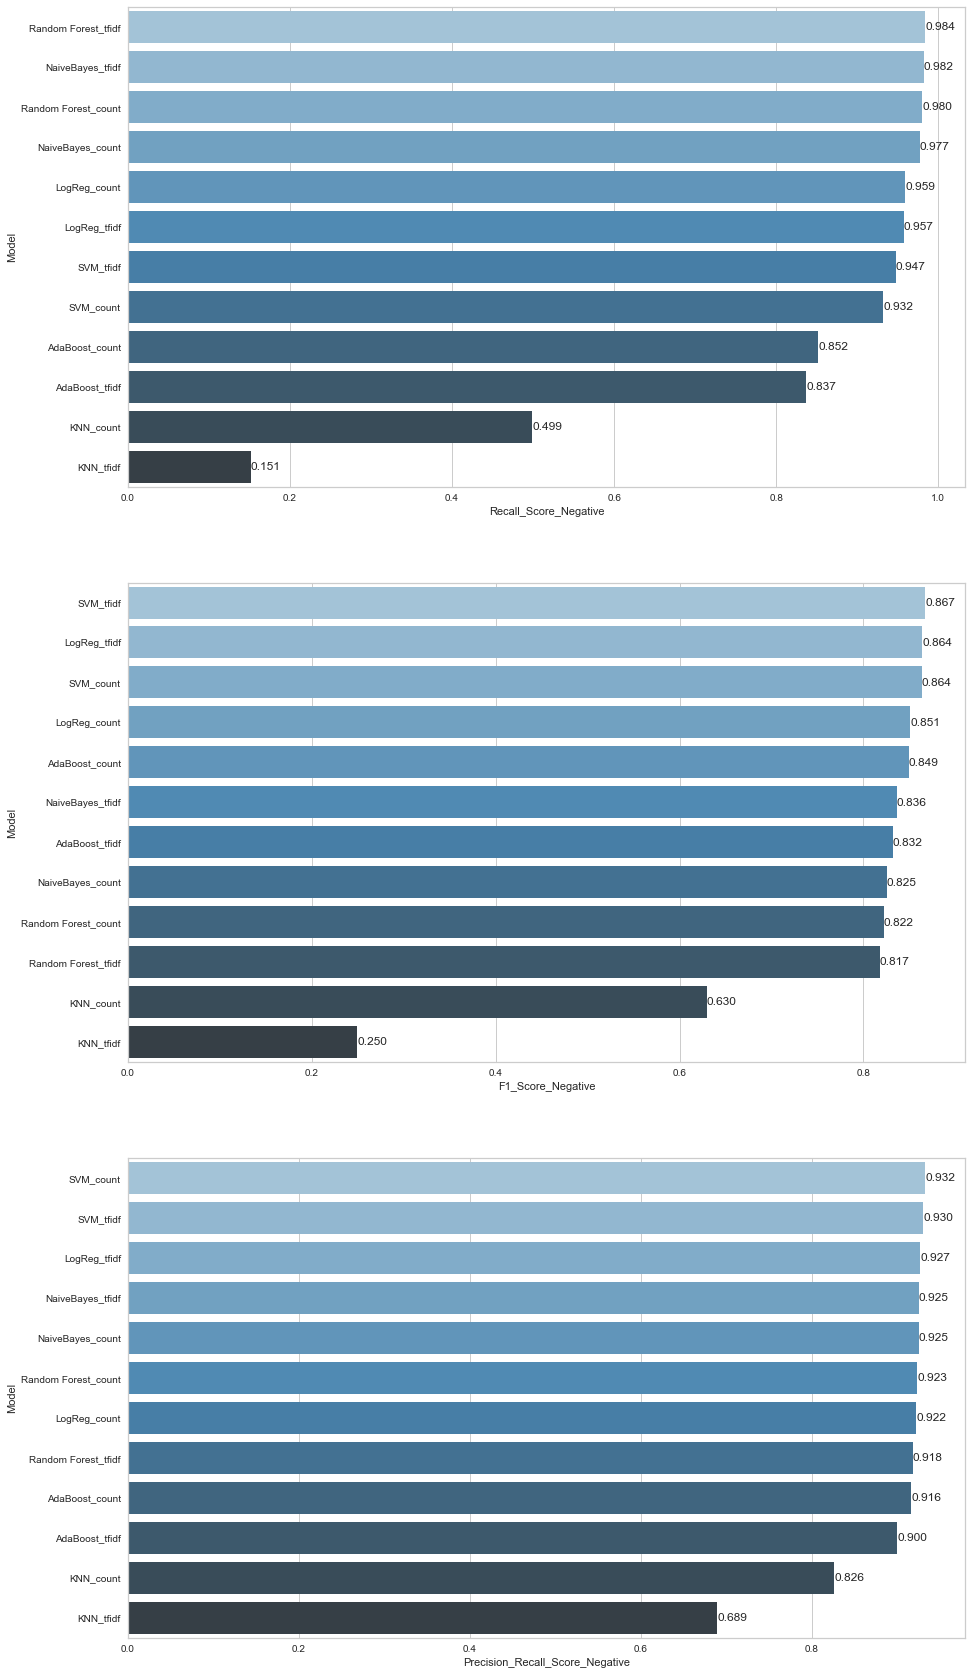

In [157]:
def labels(ax):
                        
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(15,30))
plt.subplot(311)
compare = compare.sort_values(by="Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Recall_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="F1_Score_Negative", ascending=False)
ax=sns.barplot(x="F1_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)


plt.subplot(313)
compare = compare.sort_values(by="Precision_Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Precision_Recall_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show();

# 1. görselde Recall skorlarına göre büyükten küçüğe doğru sırala ve negatif skorları bar plot ile görselleştir
# 2. görselde f1 skorlarına göre büyükten küçüğe doğru sırala ve negatif skorları bar plot ile görselleştir
# 3. görselde Precision-recal_score a(Model genel performansına) göre büyükten küçüğe doğru sırala ve negatif skorları bar plot ile görselleştir

# Precision a neden bakmadık? Bir skorun recall u düşük f1 düşükse zaten precision düşük olacaktır
# .. Yani 2 sinden(precision, recall) dan biri düşükse f1 de düşeceği için burada precision a bakmaya gerek duymadık
# .. Siz isterseniz precision ı da ekleyip görselleştirebilirsiniz

# Yorumlar: Recallar yakın ilk görselde ama biz precision ların da yakın olmasına bakıyoruz
# Naive bayes recall da yüksek ama f1 de(yani aslında precisionda da) düşmüş
# Örneğin bir modelde  recall 0.98, preci: 0,7 . diğer modelde recall 0.96, preci:0,82 ise 
# .. buradaki recall 2 puan düşük olanı tercih edebiliriz(precision da yakın olduğu için)
# Burada SVM imi yoksa log reg mı terchi edeceğiz?
# Modelin katsayı ve parametreleri üzerinden bir analiz yapabiliyor muyum?(Log reg de bunu yapabiliyorduk, SVM de katsayı yok)
# ... log reg de feature importance özelliği var, svm de yok, ayrıca svm daha maliyetli
# O yüzden log_reg i tercih edebiliriz. Ancak SVM 5-6 puan daha yüksekse onu tercih ederdik
# Ancak çalıştığınız data sağlık ile alakalıdır ve insan hayatı ile alakalı tahmin çok kritiktir. O yüzden SVM yavaş log reg hızlı diye
# .. diye svm yi onu tercih etmemezlik yapmıyoruz

## For New Tweets, prediction with pipeline


Kullanmaya karar verdigimiz modelimiz ile prediction yapacagiz. 

In [102]:
from sklearn.pipeline import Pipeline

__Pipeline__ ile fit_transform ve fit_prediction islemlerini yapabiliyorduk. Ilk yazdigimiz fonksiyon fit_transform, ikinci yazdigimiz ise fit_prediction islemlerini yapar. 

En iyi islemin TF-IDF olduguna karar vermistik, ilk olarak bunu tanimladik, ikinci kisma Logistic Regression' da en iyi sonucu aldigimiz parametreleri tanimladik :

In [103]:
pipe = Pipeline([('tfidf',TfidfVectorizer(preprocessor=cleaning, min_df=3)),('log',LogisticRegression(C=0.4, max_iter=1000))])
# sklearn ün pipeline ın fit, transform ve predict işlemlerine izin verir
# ('tfidf',TfidfVectorizer(preprocessor=cleaning, min_df=3) : cleaning yap, sayısal değerlere dönüştür(tf-idf(scale yapıyor zaten)).
# ('log',LogisticRegression(C=0.4, max_iter=1000) : modeli uygula

In [184]:
X.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

Pipe icine X ve y' nin temizlenmemis halini veriyoruz, cunku TfidfVectorizer icine tanimladigimiz cleaning fonksiyonu bu islemi yapacak. Train ve test olarak ayirmadan tum corpus' u modele verdik :

In [104]:
pipe.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3,
                                 preprocessor=<function cleaning at 0x000002700434FF78>)),
                ('log', LogisticRegression(C=0.4, max_iter=1000))])

Yukaridaki kodlar ile modelin egitim islemleri tamamlandi. Olusturdugumuz bu model ile prediction' lar alacagiz. 

__!!!__ Modelden bir prediction alabilmek icin sample' i mutlaka series' e donusturmek gerekir. __!!!__

Prediction icin verilen sample' da noktalama isareti veya ozel karakterler olsa bile __pipe__ bu karakterleri temizleyecektir, ayrica temizlememize gerek yok.

Modelimiz asagidaki tweet' in negative bir yorum oldugunu bildi :

## Prediction

In [105]:
tweet = "it was not the worst flight i have ever been."
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [106]:
tweet = "I don't like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [107]:
tweet = "I like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [109]:
tweet = "don't enjoy flight  at all"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [110]:
tweet = "it is amazing flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [108]:
tweet = "I don't think I'll ever use American Airlines anymore"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [111]:
tweet = "ok flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

## Collect Words and Counting words

cleaning_text, yukarida CountVectorizer ile degil manuel olarak temizledigimiz text idi. Bir sonraki kodda bu yorumlarin hepsini join ile birlestirdik ve all_words degiskenine atadik :

In [159]:
tweets = cleaning_text
tweets

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight no warning communic...
14637                        please bring american airline
14638    money change flight dont answer phone suggesti...
14639    ppl need know many seat next flight plz put u ...
Name: text, Length: 14640, dtype: object

In [160]:
counter = 0
for i,j in enumerate(tweets):
    if "dont like" in j and y[i]=="negative":
        counter += 1
print(counter)
# i index numarası, j yorumun kendisi
# "don't lik"e yorum içerisinde geçiyor mu ve i. index negartif mi
# Yani "don't like" ifadesi kaç tane negatif yorumda geçiyor


14


In [161]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="positive":
        counter += 1
print(counter)
# Like yorumu geçen kaç tane pozitif yorumu var

66


In [162]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="negative":
        counter += 1
print(counter)
# Like tokeninin geçtiği kaç tane olumsuz yorum var
# Model: like kelimesi olumlu ve olumsuz yorumlarda geçiyor ama olumsuz olma olasılığı daha yüksek
# O yüzden model yukardaki tahminleri yanlış yaptı
# Countvektozier ve TF-IDF de tokenlerin birbirleriyle olan anlamsal ilişkileri yakalayamıyor
# .. bunu wordembedding dersinde bakacağız bu konuya detaylı

# "like" bir keyword olmaktan çıktı. Çünkü hem olumlularda hem de olumsuzlarda sıklıkla geçiyor. Yani bir nevi stopword olmuş
# "dont like" bir keyword olabilir

304


In [163]:
counter = 0
for i,j in enumerate(tweets):
    if "isnt amazing" in j and y[i]=="negative":
        counter += 1
print(counter)
# Datada isnt ile amazing hiç bir araya gelmemiş. Yani amazing e olumlu diyip amazing görünce olumlu deyip
# .. onu olumluya atıyor

0


## WordCloud - Repetition of Words

Bu asamada corpus' ta siklikla kullanilmis olan tokenleri gorsellestirecegiz. Bunun icin __wordcloud__ kutuphanesini import edecegiz. 

In [164]:
tweets = cleaning_text
tweets

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight no warning communic...
14637                        please bring american airline
14638    money change flight dont answer phone suggesti...
14639    ppl need know many seat next flight plz put u ...
Name: text, Length: 14640, dtype: object

In [165]:
all_words = " ".join(tweets) # Bütün yorumları tek bir cümle gibi birleştirdik

In [166]:
all_words[:100] # ilk 100 karakter

'said plus youve added commercial experience tacky didnt today must mean need take another trip reall'

## Create Word Cloud

In [178]:
# !pip install wordcloud
#conda install -c conda-forge wordcloud

In [179]:
from wordcloud import WordCloud

__background_color :__ Arka plan rengini ayarlar.

__max_words =250 :__ En fazla kullanilan 250 kelimeyi goster. (Baska sayilar verilebilir.)

In [180]:
worldcloud = WordCloud(background_color="white", max_words =250)

__worldcloud.generate(all_words) :__ tokenleri gez generate ile en fazla kullanilan 250 kelimeye ait gorselin yapisi arka planda olusturulur.

In [181]:
worldcloud.generate(all_words)

Gorsellestirme icin matplotlib altyapisini kullandik. imshow icine olusturdugumuz wordcloud' i verince corpus icinde daha cok gecen ifadeler daha buyuk harfli olarak gorselestirilmis oldu :

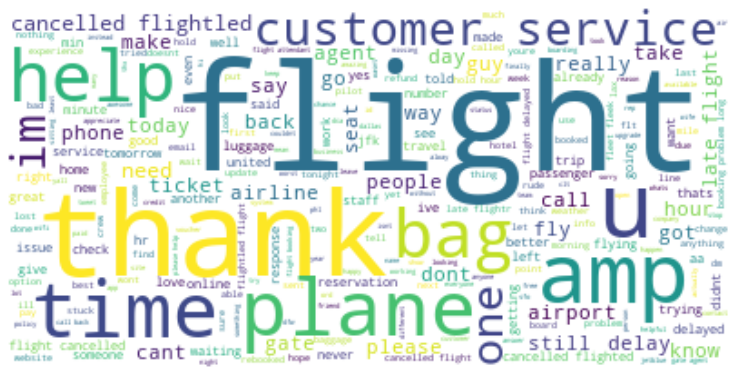

In [183]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13,13))
plt.imshow(worldcloud, interpolation="bilinear",)                 # interpolation : renklendirme
plt.axis("off")                                                   # Cerceve olsun mu?
plt.show()

# Datamda en fazla kullanılan 250 token. wordcloud ı sadece notebook a bir görselleştirme katmak için yapıyoruz

#### class chat: WordCloud'un içerisinde mask parametresi bulunuyor buraya background için istediğimiz resmi-şablonu koyabiliyoruz
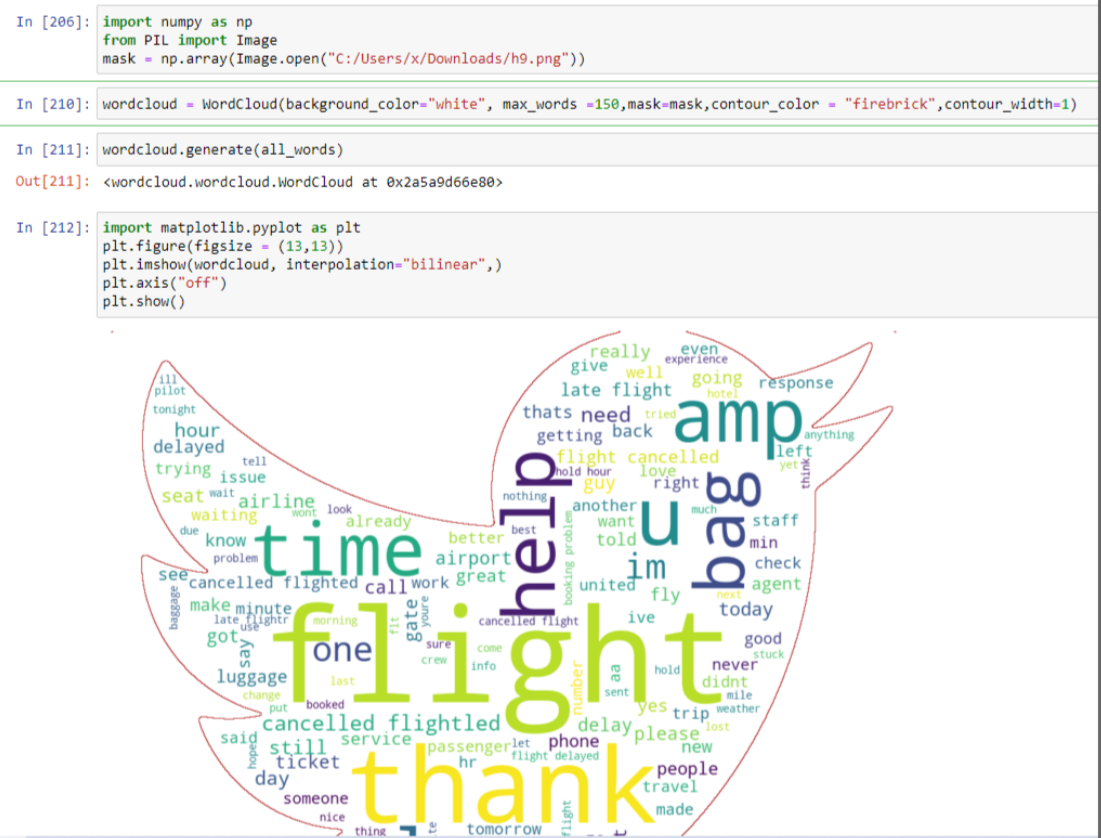
